Random φ: [1 5 0 4 8 0 1 2]


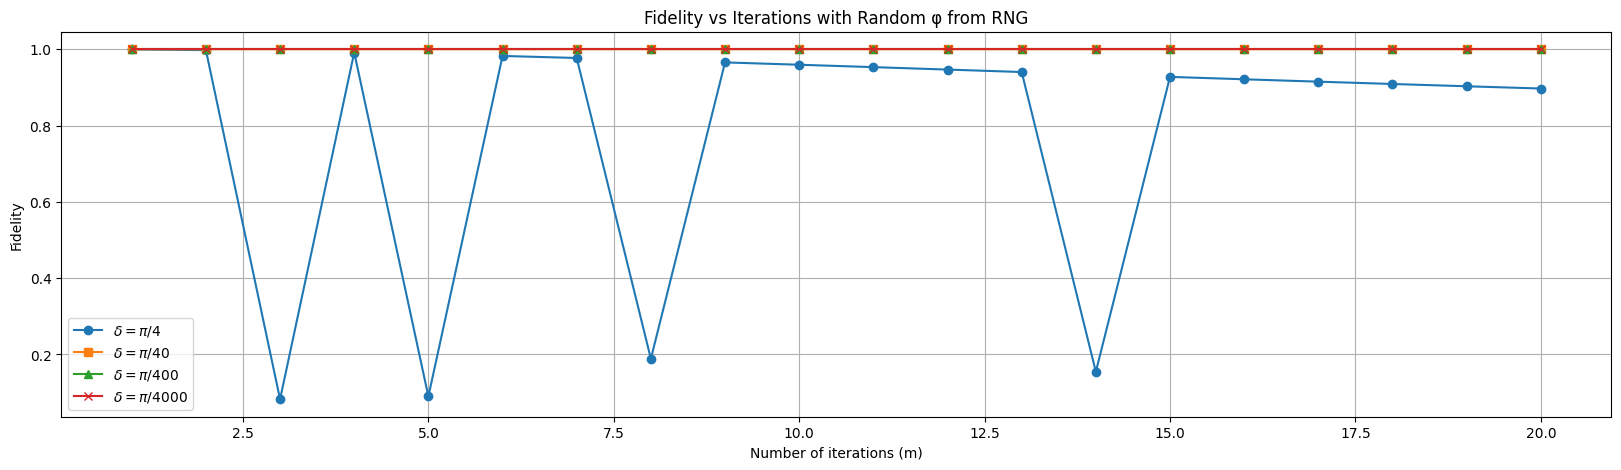

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
from qiskit_mps_initializer.datatypes import QuantumState

# import your RNG
from nRNG import generate_multiple_digits

# --- parameters ---
N = 8                      # dimension of ψ and φ
n = 3                      # number of qubits (log2(N))
number_of_layers = 2       # MPS initializer layers

# --- define psi and random phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = generate_multiple_digits(N)   # random φ from RNG
print("Random φ:", phi)

# normalize states
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# generate circuits
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

def run_protocol(m, delta, return_state=False):
    # --- setup quantum registers and circuit ---
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    # initialize MPS states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(1, m+1):
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)
        if k < m:
            qc.append(U_phi, phi_reg)

    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # ideal target
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    fid = state_fidelity(rho_psi, rho_ideal)

    # ✅ return fidelity + states if requested
    if return_state:
        return fid, rho_psi, ideal_vec
    else:
        return fid


# --- run for multiple iterations ---
m_values = list(range(1, 21))

delta0 = np.pi / 4
delta1 = np.pi / 40
delta2 = np.pi / 400
delta3 = np.pi / 4000

fidelities0 = [run_protocol(m, delta0) for m in m_values]
fidelities1 = [run_protocol(m, delta1) for m in m_values]
fidelities2 = [run_protocol(m, delta2) for m in m_values]
fidelities3 = [run_protocol(m, delta3) for m in m_values]

# --- plot results ---
plt.figure(figsize=(20,5))
plt.plot(m_values, fidelities0, 'o-', label=r'$\delta = \pi/4$')
plt.plot(m_values, fidelities1, 's-', label=r'$\delta = \pi/40$')
plt.plot(m_values, fidelities2, '^-', label=r'$\delta = \pi/400$')
plt.plot(m_values, fidelities3, 'x-', label=r'$\delta = \pi/4000$')
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations with Random φ from RNG")
plt.legend()
plt.grid(True)
plt.show()


Example m=20, δ=0.00785: Fidelity=1.000000


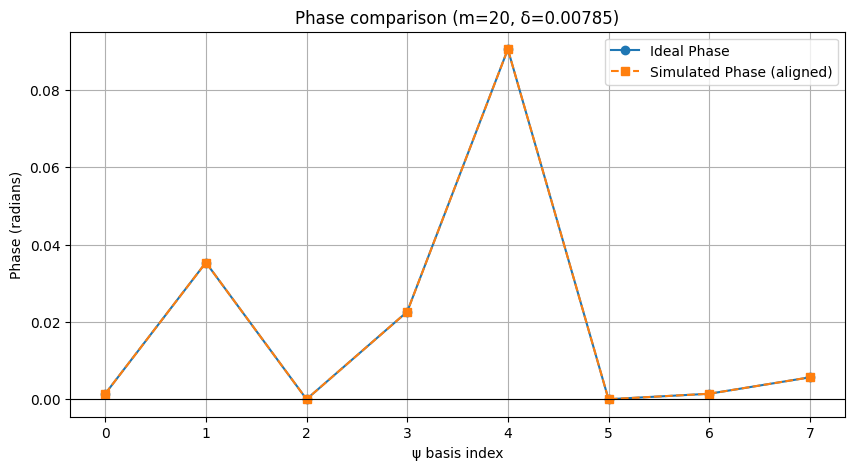

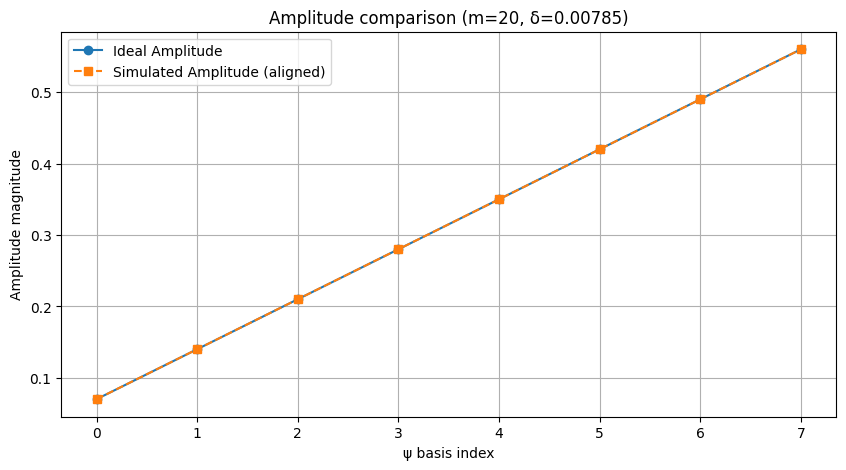

In [2]:
# --- choose example parameters ---
m_example = 20
delta_example = np.pi/400

# run protocol
fid_ex, rho_psi, ideal_vec = run_protocol(m_example, delta_example, return_state=True)
vec_sim = np.array(rho_psi.to_statevector())

# --- align global phase ---
global_phase = np.angle(np.vdot(ideal_vec, vec_sim))
vec_sim_aligned = vec_sim * np.exp(-1j * global_phase)

# --- amplitudes and phases ---
amps_ideal = np.abs(ideal_vec)
amps_sim = np.abs(vec_sim_aligned)
phases_ideal = np.unwrap(np.angle(ideal_vec))
phases_sim = np.unwrap(np.angle(vec_sim_aligned))

print(f"Example m={m_example}, δ={delta_example:.5f}: Fidelity={fid_ex:.6f}")

# --- Phase comparison plot ---
plt.figure(figsize=(10,5))
plt.plot(range(N), phases_ideal, 'o-', label="Ideal Phase")
plt.plot(range(N), phases_sim, 's--', label="Simulated Phase (aligned)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("ψ basis index")
plt.title(f"Phase comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()

# --- Amplitude comparison plot ---
plt.figure(figsize=(10,5))
plt.plot(range(N), amps_ideal, 'o-', label="Ideal Amplitude")
plt.plot(range(N), amps_sim, 's--', label="Simulated Amplitude (aligned)")
plt.ylabel("Amplitude magnitude")
plt.xlabel("ψ basis index")
plt.title(f"Amplitude comparison (m={m_example}, δ={delta_example:.5f})")
plt.legend()
plt.grid(True)
plt.show()